In [1]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Dataset

In [2]:
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)

## Model

In [3]:
class Experiment_1:
    def __init__(self):
        self.W1 = torch.randn(784, 100, device=device, requires_grad=True)  
        self.b1 = torch.randn(100, device=device, requires_grad=True)  
        self.W2 = torch.randn(100, 10, device=device, requires_grad=True)  
        self.b2 = torch.randn(10, device=device, requires_grad=True)  
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  
        x = torch.matmul(x, self.W1) + self.b1  
        x = torch.maximum(x, torch.zeros_like(x))  
        x = torch.matmul(x, self.W2) + self.b2 
        return x
    


class Experiment_2:
    def __init__(self):
        self.layers = []
        self.biases = []
        
        self.layers.append(torch.randn(784, 100, device=device, requires_grad=True))
        self.biases.append(torch.randn(100, device=device, requires_grad=True))
        
        for _ in range(8):
            self.layers.append(torch.randn(100, 100, device=device, requires_grad=True))
            self.biases.append(torch.randn(100, device=device, requires_grad=True))
        
        self.layers.append(torch.randn(100, 10, device=device, requires_grad=True))
        self.biases.append(torch.randn(10, device=device, requires_grad=True))
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for i in range(9):
            x = torch.matmul(x, self.layers[i]) + self.biases[i]
            x = torch.maximum(x, torch.zeros_like(x))
        x = torch.matmul(x, self.layers[-1]) + self.biases[-1]
        return x
    


class Experiment_3:
    def __init__(self):
        self.layers = []
        self.biases = []

        self.layers.append(torch.randn(784, 100, device=device, requires_grad=True))
        self.biases.append(torch.randn(100, device=device, requires_grad=True))

        for _ in range(8):
            self.layers.append(torch.randn(100, 100, device=device, requires_grad=True))
            self.biases.append(torch.randn(100, device=device, requires_grad=True))

        self.layers.append(torch.randn(100, 10, device=device, requires_grad=True))
        self.biases.append(torch.randn(10, device=device, requires_grad=True))
    
    def normalize(self, x):
        mu = torch.mean(x, dim=1, keepdim=True)
        sigma = torch.std(x, dim=1, keepdim=True)
        return (x - mu) / sigma 
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for i in range(9):
            x = self.normalize(x)
            x = torch.matmul(x, self.layers[i]) + self.biases[i]
            x = torch.maximum(x, torch.zeros_like(x))
        x = self.normalize(x)
        x = torch.matmul(x, self.layers[-1]) + self.biases[-1]
        return x

## Loss

In [4]:
criterion = torch.nn.CrossEntropyLoss()

## Train model for Experiment 1

In [5]:
model = Experiment_1()
learning_rate_1 = 1.0
train_loss_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in range(10):
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        outputs = model.forward(x_batch)
        loss = criterion(outputs, y_batch)
        
        loss.backward()
        with torch.no_grad():
            model.W1 -= learning_rate_1 * model.W1.grad
            model.b1 -= learning_rate_1 * model.b1.grad
            model.W2 -= learning_rate_1 * model.W2.grad
            model.b2 -= learning_rate_1 * model.b2.grad
        
        model.W1.grad.zero_()
        model.b1.grad.zero_()
        model.W2.grad.zero_()
        model.b2.grad.zero_()
    
    with torch.no_grad():
        test_x, test_y = next(iter(test_loader))
        test_x, test_y = test_x.to(device), test_y.to(device)
        test_outputs = model.forward(test_x)
        
        test_loss = criterion(test_outputs, test_y).item()
        test_loss_history.append(test_loss)
        predicted = torch.argmax(test_outputs, dim=1)
        accuracy = (predicted == test_y).float().mean().item()
        test_accuracy_history.append(accuracy)
    
    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")


Epoch 1, Test Loss: 0.5466, Test Accuracy: 0.8535
Epoch 2, Test Loss: 0.4106, Test Accuracy: 0.8946
Epoch 3, Test Loss: 0.3755, Test Accuracy: 0.9055
Epoch 4, Test Loss: 0.3099, Test Accuracy: 0.9180
Epoch 5, Test Loss: 0.3000, Test Accuracy: 0.9241
Epoch 6, Test Loss: 0.4366, Test Accuracy: 0.8726
Epoch 7, Test Loss: 0.2909, Test Accuracy: 0.9263
Epoch 8, Test Loss: 0.2873, Test Accuracy: 0.9279
Epoch 9, Test Loss: 0.2674, Test Accuracy: 0.9327
Epoch 10, Test Loss: 0.2828, Test Accuracy: 0.9314


## Plot for Experiment 1

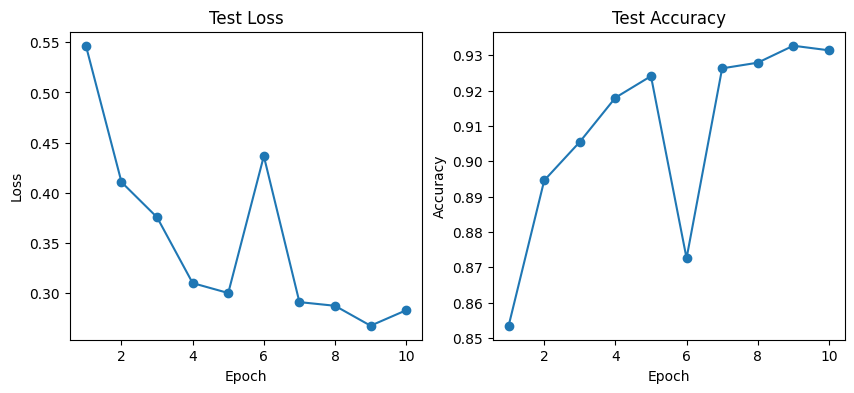

In [6]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), test_loss_history, marker='o')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), test_accuracy_history, marker='o')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

## Train model for Experiment 2

In [7]:
learning_rate_2 = 1
model = Experiment_2()

for epoch in range(10):
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        outputs = model.forward(x_batch)
        loss = criterion(outputs, y_batch)
        
        loss.backward()
        with torch.no_grad():
            for i in range(len(model.layers)):

                model.layers[i] -= learning_rate_2 * model.layers[i].grad
                model.biases[i] -= learning_rate_2 * model.biases[i].grad
                
                model.layers[i].grad.zero_()
                model.biases[i].grad.zero_()
    
    with torch.no_grad():
        test_x, test_y = next(iter(test_loader))
        test_x, test_y = test_x.to(device), test_y.to(device)
        test_outputs = model.forward(test_x)
        
        test_loss = criterion(test_outputs, test_y).item()
        predicted = torch.argmax(test_outputs, dim=1)
        accuracy = (predicted == test_y).float().mean().item()
    
    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

Epoch 1, Test Loss: nan, Test Accuracy: 0.0980
Epoch 2, Test Loss: nan, Test Accuracy: 0.0980
Epoch 3, Test Loss: nan, Test Accuracy: 0.0980
Epoch 4, Test Loss: nan, Test Accuracy: 0.0980
Epoch 5, Test Loss: nan, Test Accuracy: 0.0980
Epoch 6, Test Loss: nan, Test Accuracy: 0.0980
Epoch 7, Test Loss: nan, Test Accuracy: 0.0980
Epoch 8, Test Loss: nan, Test Accuracy: 0.0980
Epoch 9, Test Loss: nan, Test Accuracy: 0.0980
Epoch 10, Test Loss: nan, Test Accuracy: 0.0980


## Plot for Experiment 2

Since the gradient exploded and no meaningful training happened in Experiment 2, I will not add the plot

## Training for Experiment 3

In [8]:
learning_rate_3 = 1
model = Experiment_3()
test_loss_history_3 = []
test_accuracy_history_3 = []

for epoch in range(10):
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        outputs = model.forward(x_batch)
        loss = criterion(outputs, y_batch)
        
        loss.backward()
        
        with torch.no_grad():
            for i in range(len(model.layers)):
                model.layers[i] -= learning_rate_3 * model.layers[i].grad
                model.biases[i] -= learning_rate_3 * model.biases[i].grad
                
                model.layers[i].grad.zero_()
                model.biases[i].grad.zero_()
    
    with torch.no_grad():
        test_x, test_y = next(iter(test_loader))
        test_x, test_y = test_x.to(device), test_y.to(device)
        test_outputs = model.forward(test_x)
        
        test_loss = criterion(test_outputs, test_y).item()  
        test_loss_history_3.append(test_loss)
        predicted = torch.argmax(test_outputs, dim=1)
        accuracy = (predicted == test_y).float().mean().item()
        test_accuracy_history_3.append(accuracy)
    
    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

Epoch 1, Test Loss: 0.2964, Test Accuracy: 0.9173
Epoch 2, Test Loss: 0.2359, Test Accuracy: 0.9336
Epoch 3, Test Loss: 0.2191, Test Accuracy: 0.9384
Epoch 4, Test Loss: 0.2127, Test Accuracy: 0.9414
Epoch 5, Test Loss: 0.1912, Test Accuracy: 0.9470
Epoch 6, Test Loss: 0.1843, Test Accuracy: 0.9505
Epoch 7, Test Loss: 0.1878, Test Accuracy: 0.9498
Epoch 8, Test Loss: 0.1902, Test Accuracy: 0.9528
Epoch 9, Test Loss: 0.1883, Test Accuracy: 0.9530
Epoch 10, Test Loss: 0.1972, Test Accuracy: 0.9527


## Plot for Experiment 3

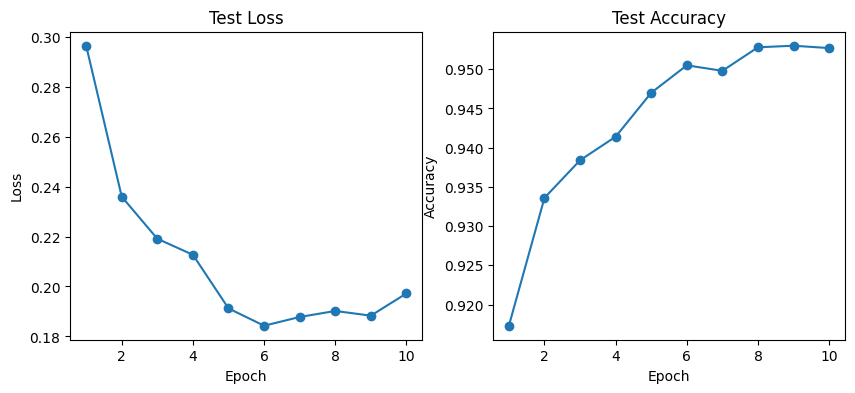

In [9]:
plt.figure(figsize=(10, 4))


plt.subplot(1, 2, 1)
plt.plot(range(1, 11), test_loss_history_3, marker='o')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.subplot(1, 2, 2)
plt.plot(range(1, 11), test_accuracy_history_3, marker='o')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

## Discussion

For experiment 1, the model is shallow enough that no gradient explodion happened, so the result is reasonable.

For experiment 2, the model is much deeper with 9 more layers, and gradient exploded, under the requirements of this experiment I cannot stablize the training disregard of the learning rate.

For experiment 3, with normalization, the training is stablized and the deeper network marginally improved the final testing accuracy when comparing to experiment 1.